In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"


In [2]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [15]:
parameter_values.search("porosity")

Negative electrode porosity	0.3
Positive electrode porosity	0.3
Separator porosity	0.4


In [4]:
cell = 1

In [5]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 18, 57, 93, 134, 175, 216, 257, 298, 339


In [6]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " until 3V"
    # eps_n_data = 0.6234
    # eps_p_data = 0.4542
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"

In [7]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Charge at "+c_rate_c+" until 4.2V", )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [8]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [9]:
parameter_values = get_parameter_values()
sim_des = '_lowc'
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)

In [10]:
sim_exp = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_exp = sim_exp.solve(initial_soc=0)

In [19]:
spm.variable_names()

['Time',
 'Time [s]',
 'Time [min]',
 'Time [h]',
 'x',
 'x [m]',
 'x_n',
 'x_n [m]',
 'x_s',
 'x_s [m]',
 'x_p',
 'x_p [m]',
 'Sum of electrolyte reaction source terms',
 'Sum of positive electrode electrolyte reaction source terms',
 'Sum of x-averaged positive electrode electrolyte reaction source terms',
 'Sum of interfacial current densities',
 'Sum of positive electrode interfacial current densities',
 'Sum of x-averaged positive electrode interfacial current densities',
 'Sum of negative electrode electrolyte reaction source terms',
 'Sum of x-averaged negative electrode electrolyte reaction source terms',
 'Sum of negative electrode interfacial current densities',
 'Sum of x-averaged negative electrode interfacial current densities',
 'r_p',
 'r_p [m]',
 'r_n',
 'r_n [m]',
 'Current density variable',
 'Total current density',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Porosity',
 'Separator porosity',
 'Positive electrode porosi

In [20]:
t = sol_exp["Time [min]"].entries
I = sol_exp["Current [A]"].entries
Q = -sol_exp['Discharge capacity [A.h]'].entries
Vt = sol_exp["Terminal voltage [V]"].entries
exp = 30e6*sol_exp["Cell thickness change [m]"].entries
ee_p = sol_exp["X-averaged positive electrode porosity"].entries
ee_n = sol_exp["X-averaged negative electrode porosity"].entries
ee_s = sol_exp["X-averaged separator porosity"].entries

Text(0, 0.5, 'Porosity')

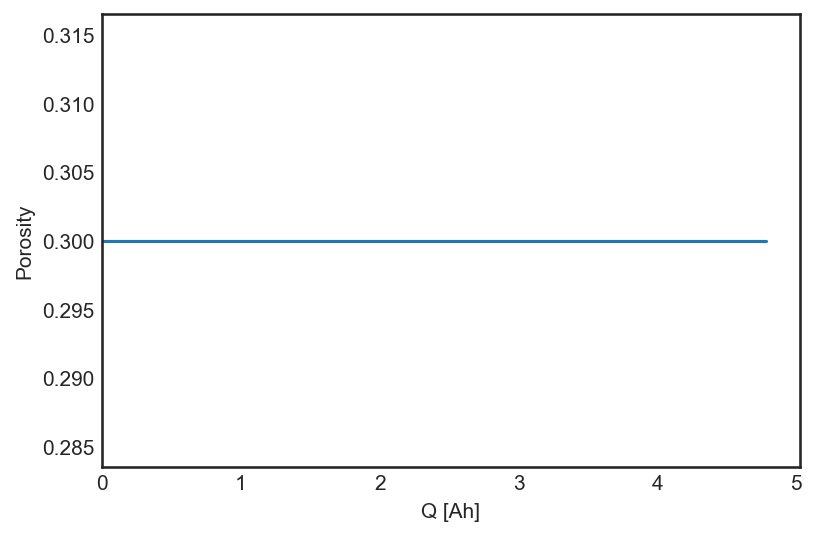

In [21]:
plt.figure()

plt.plot(Q,ee_p)
plt.xlim(left=0)
plt.xlabel('Q [Ah]')
plt.ylabel('Porosity')

['Time',
 'Time [s]',
 'Time [min]',
 'Time [h]',
 'x',
 'x [m]',
 'x_n',
 'x_n [m]',
 'x_s',
 'x_s [m]',
 'x_p',
 'x_p [m]',
 'Sum of electrolyte reaction source terms',
 'Sum of positive electrode electrolyte reaction source terms',
 'Sum of x-averaged positive electrode electrolyte reaction source terms',
 'Sum of interfacial current densities',
 'Sum of positive electrode interfacial current densities',
 'Sum of x-averaged positive electrode interfacial current densities',
 'Sum of negative electrode electrolyte reaction source terms',
 'Sum of x-averaged negative electrode electrolyte reaction source terms',
 'Sum of negative electrode interfacial current densities',
 'Sum of x-averaged negative electrode interfacial current densities',
 'r_p',
 'r_p [m]',
 'r_n',
 'r_n [m]',
 'Current density variable',
 'Total current density',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Porosity',
 'Separator porosity',
 'Positive electrode porosi